In [3]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Descriptors
import numpy as np
from rdkit.Chem import AllChem
from rdkit.Chem import rdPartialCharges
import torch
from torch import nn
from torch.utils.data import Dataset,DataLoader
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.metrics import accuracy_score

import numpy as np
import pandas as pd

In [5]:
df = pd.read_csv(r'DrugBank_uni_esm2_3B.csv')
df.head()

,0,1,SMILES,Target_sequence,Label,unimol_encoding,target_embedding
0,DB00303,P45059,[H][C@]12[C@@H](C)C(S[C@]3([H])CN[C@@]([H])(C3...,MVKFNSSRKSGKSKKTIRKLTAPETVKQNKPQKVFEKCFMRGRYML...,1,"[-0.2632623314857483, -0.11634709686040878, 0....","[3.937832, -4.5610986, -1.5059096, 4.763294, 3..."
1,DB00114,P19113,CC1=NC=C(COP(O)(O)=O)C(C=O)=C1O,MMEPEEYRERGREMVDYICQYLSTVRERRVTPDVQPGYLRAQLPES...,1,"[-0.5830875039100647, 0.39205265045166016, 1.1...","[5.119278, -7.4051247, 3.8747115, 3.124652, -1..."
2,DB00117,P19113,N[C@@H](CC1=CNC=N1)C(O)=O,MMEPEEYRERGREMVDYICQYLSTVRERRVTPDVQPGYLRAQLPES...,1,"[-0.4533002972602844, 0.5464305877685547, 0.62...","[5.119278, -7.4051247, 3.8747115, 3.124652, -1..."
3,DB00142,Q9UI32,N[C@@H](CCC(O)=O)C(O)=O,MRSMKALQKALSRAGSHCGRGGWGHPSRSPLLGGGVRHHLSEAAAQ...,1,"[-0.586250364780426, 0.7800034284591675, 0.574...","[3.8181303, -4.1893578, 5.340713, 1.8750579, 4..."
4,DB01839,P00488,CC(O)CO,MSETSRTAFGGRRAVPPNNSNAAEDDLPTVELQGVVPRGVNLQEFL...,1,"[0.13164080679416656, -0.04532823711633682, 0....","[4.22107, -0.49930394, -1.755277, 1.344187, -4..."


In [6]:
! nvidia-smi

Tue May 21 23:23:03 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100S-PCI...  On   | 00000000:00:0A.0 Off |                  Off |
| N/A   30C    P0    25W / 250W |      0MiB / 32768MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [7]:
def str_to_np_array(str):
    str = str.replace("\n", "")
    str = str.replace("[", "") 
    str = str.replace("]", "") 
    str_vals = str.split(",")   
    return np.array(str_vals, dtype=np.float32)



df['target_embedding'] = df['target_embedding'].apply(str_to_np_array)
df['unimol_encoding'] = df['unimol_encoding'].apply(eval)
df = df.dropna()




In [8]:
if torch.cuda.is_available():
    print("CUDA is available. You can use GPU.")
else:
    print("CUDA is not available. GPU is not supported on this system.")


CUDA is available. You can use GPU.


In [9]:
torch.cuda.device_count()

1

****Dataset Split****

In [11]:
train_df = df.sample(frac=0.7, random_state=200)
temp_df = df.drop(train_df.index)
valid_df = temp_df.sample(frac=0.66, random_state=200)
test_df = temp_df.drop(valid_df.index)

In [12]:
train_df = train_df.reset_index(drop=True)
valid_df = valid_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

train_df.head()

,0,1,SMILES,Target_sequence,Label,unimol_encoding,target_embedding
0,DB02103,Q12866,[H][C@@]1(CO)CC[C@@]([H])(O1)N1C=NC2=C1N=C(Cl)...,MGPAPLPLLLGLFLPALWRRAITEAREEAKPYPLFPGPFPGSLQTD...,0,"[-0.40939849615097046, -0.5894134640693665, 0....","[3.5828826, -5.9347024, 0.88416725, 3.0007079,..."
1,DB00675,P71278,CC\C(=C(/C1=CC=CC=C1)C1=CC=C(OCCN(C)C)C=C1)C1=...,MSAEKLFTPLKVGAVTAPNRVFMAPLTRLRSIEPGDIPTPLMGEYY...,0,"[-0.19765575230121613, -0.27443504333496094, 0...","[1.8634391, -13.034275, 2.6959229, 1.3616855, ..."
2,DB08339,P00747,CN1C(=O)C(=CC2=CN=C(NC3=CC(CO)=CC=C3)N=C12)C1=...,MEHKEVVLLLLLFLKSGQGEPLDDYVNTQGASLFSVTKKQLGAGSI...,0,"[-0.23785123229026794, -0.6222177743911743, 0....","[4.1191025, -10.820947, -5.6943016, 0.69438905..."
3,DB07631,P11797,CCCCCCCCCCCC[N+](C)(C)CC([O-])=O,MSTRKAVIGYYFIPTNQINNYTETDTSVVPFPVSNITPAKAKQLTH...,0,"[-0.11077546328306198, -0.4805830419063568, -0...","[2.1227875, -4.793505, -5.8333445, -4.3458276,..."
4,DB02054,O43681,NC1=CC=CC(=C1)C(O)=O,MAAGVAGWGVEAEEFEDAPDVEPLEPTLSNIIEQRSLKWIFVGGKG...,0,"[-0.40276050567626953, 0.3623400330543518, 0.0...","[5.0765696, -10.657153, 8.738444, 6.264897, -3..."


****Model****

In [14]:
import torch
import torch.nn as nn

class TransVecNet(nn.Module):
    def __init__(self, target_embed_len=2560, drug_embed_len=512, nhead=4, num_layers=8, dropout=0.5):
        super(TransVecNet, self).__init__()

        self.target_encoder_layer = nn.TransformerEncoderLayer(d_model=target_embed_len, nhead=nhead)
        self.target_transformer_encoder = nn.TransformerEncoder(self.target_encoder_layer, num_layers=num_layers)

        self.drug_encoder_layer = nn.TransformerEncoderLayer(d_model=drug_embed_len, nhead=nhead)
        self.drug_transformer_encoder = nn.TransformerEncoder(self.drug_encoder_layer, num_layers=num_layers)

        self.bilinear_pooling = nn.Bilinear(target_embed_len, drug_embed_len, 1, bias=False)

        self.fc1 = nn.Linear(target_embed_len + drug_embed_len + 1, 2048)  # +1 for the bilinear term
        self.fc2 = nn.Linear(2048, 1024)
        self.fc3 = nn.Linear(1024, 512)
        self.fc4 = nn.Linear(512, 256)
        self.fc5 = nn.Linear(256, 128)
        self.fc6 = nn.Linear(128, 1)

        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)

    def forward(self, target_input, drug_input):
        target_input = target_input.unsqueeze(0)
        drug_input = drug_input.unsqueeze(0)

        x_target = self.target_transformer_encoder(target_input)
        x_drug = self.drug_transformer_encoder(drug_input)

        # Using mean pooling for both target and drug embeddings
        x_target_avg = torch.mean(x_target, dim=0)
        x_drug_avg = torch.mean(x_drug, dim=0)

        bilinear_term = self.bilinear_pooling(x_target_avg, x_drug_avg)
        # Concatenate target, drug embeddings and bilinear term
        x = torch.cat((x_target_avg, x_drug_avg, bilinear_term), dim=1)

        x = self.relu(self.fc1(x))
        x = self.dropout(self.relu(self.fc2(x)))
        x = self.relu(self.fc3(x))
        x = self.relu(self.fc4(x))
        x = self.dropout(self.relu(self.fc5(x)))
        x = self.fc6(x)
        return x


In [15]:
class MoleculeDataset(Dataset):
    def __init__(self, df):
        self.df = df

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        molecule_data = torch.tensor(self.df.loc[idx, 'unimol_encoding'])
       
        protein_data = torch.tensor(self.df.loc[idx, 'target_embedding']) 
        
        label = torch.tensor(self.df['Label'].iloc[idx]).view(-1, 1)

        return molecule_data, protein_data, label


****DataLoader****

In [16]:

batch_size = 32  
train_dataset = MoleculeDataset(train_df)
valid_dataset = MoleculeDataset(valid_df)
test_dataset = MoleculeDataset(test_df)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)  

train_loader



****Train and Test****

In [17]:

from sklearn.metrics import roc_auc_score, accuracy_score, recall_score, average_precision_score

def metrics(y_true, y_pred, threshold=0.5):
    y_bin = (torch.sigmoid(torch.tensor(y_pred)) > threshold).float().tolist()
    auc_roc = roc_auc_score(y_true, y_pred)  
    acc = accuracy_score(y_true, y_bin) 
    recall = recall_score(y_true, y_bin) 
    aupr = average_precision_score(y_true, y_pred)  
    
    return auc_roc, acc, recall, aupr

def train(model, device, train_loader, criterion, optimizer, epoch, best_val_loss, best_val_auc, model_path):
    model.train()
    train_losses = []
    y_true = []
    y_pred = []
    y_true_bin = [] 
    y_pred_bin = [] 
    for batch_idx, (molecule_data, protein_data, target) in enumerate(train_loader):
        molecule_data, protein_data, target = molecule_data.float().to(device), protein_data.float().to(device), target.float().to(device)
        optimizer.zero_grad()
        output = model(protein_data, molecule_data)
        target = target.squeeze(1)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss = loss.item()
        train_losses.append(train_loss)

      
        pred = (torch.sigmoid(output) > 0.5).float()
        
        y_true.extend(target.tolist())
        y_pred.extend(torch.sigmoid(output).tolist()) 

       
        y_true_bin.extend(target.tolist())
        y_pred_bin.extend(pred.squeeze().tolist())

    train_loss_avg = sum(train_losses) / len(train_losses)
    train_auc = roc_auc_score(y_true, y_pred)
    train_acc = accuracy_score(y_true_bin, y_pred_bin)

    print('Train Epoch: {} \tLoss: {:.6f} \tAUC: {:.6f} \tAccuracy: {:.6f}'.format(
        epoch, train_loss_avg, train_auc, train_acc))
    
    val_loss, val_auc, val_acc = validate(model, device, valid_loader, criterion)
    
  
    current_model_path = f"{model_path}_loss-{val_loss:.4f}_auc-{val_auc:.4f}.pt"
    torch.save(model.state_dict(), current_model_path)
    print(f'Model saved as {current_model_path}')
    
  
    if val_loss < best_val_loss:
        best_val_loss = val_loss
    if val_auc > best_val_auc:
        best_val_auc = val_auc
    
    return train_loss_avg, train_auc, train_acc, best_val_loss, best_val_auc



def validate(model, device, valid_loader, criterion):
    model.eval()
    validate_loss = 0.0
    y_true = []
    y_pred = []
    y_true_bin = [] 
    y_pred_bin = [] 
    print('start validation')
    with torch.no_grad():
        for idx, (molecule_data, protein_data, target) in enumerate(valid_loader):
            molecule_data, protein_data, target = molecule_data.float().to(device), protein_data.float().to(device), target.float().to(device)
            
            output = model(protein_data, molecule_data)
            target = target.squeeze(1)
            validate_loss += criterion(output, target).item()
            
            pred = (torch.sigmoid(output) > 0.5).float()
            y_true_bin.extend(target.tolist())
            y_pred_bin.extend(pred.squeeze().tolist())
            
            y_true.extend(target.tolist())
            y_pred.extend(torch.sigmoid(output).tolist()) 

    validate_loss /= len(valid_loader.dataset)
    val_acc = accuracy_score(y_true_bin, y_pred_bin)
    val_auc = roc_auc_score(y_true, y_pred)

    print('\nValidation set: Average loss: {:.6f}, AUC: {:.6f}, Accuracy: {:.6f}\n'.format(
        validate_loss, val_auc, val_acc))
    
    return validate_loss, val_auc, val_acc



def test(model, device, test_loader, criterion):
    model.eval()
    test_loss = 0.0
    y_true = []
    y_pred = []

    print('start testing')
    with torch.no_grad():
        for idx, (molecule_data, protein_data, target) in enumerate(test_loader):
            molecule_data, protein_data, target = molecule_data.float().to(device), protein_data.float().to(device), target.float().to(device)
            
            output = model(protein_data, molecule_data)
            target = target.squeeze(1)
            test_loss += criterion(output, target).item()
            
            y_pred.extend(output.tolist())
            
            y_true.extend(target.tolist())

    test_loss /= len(test_loader)  
    test_auc, test_acc, test_recall,  test_aupr = metrics(y_true, y_pred)
    test_auc1 = roc_auc_score(y_true, y_pred)

    print('\nTest set: Average loss: {:.6f}, AUC: {:.6f}, Accuracy: {:.6f}, Recall: {:.6f}, AUPR: {:.6f}\n'.format(
        test_loss, test_auc1, test_acc, test_recall, test_aupr))
    
    return test_loss, test_auc1, test_acc, test_recall, test_aupr

In [18]:
history = {
    'train_loss': [],
    'train_auc': [],
    'train_acc': [],  
    'valid_loss': [],
    'valid_auc': [],
    'valid_acc': [],  
    'test_loss': [],
    'test_auc': [],
    'test_acc': []  
}
device = torch.device('cuda')
model = TransVecNet(target_embed_len=2560, drug_embed_len=512).to(device)




criterion = nn.BCEWithLogitsLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.000005,weight_decay=0.001)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.1)


epochs = 20
model_path = 'best_model1.pt'  
best_val_loss = float('inf')   
best_val_auc = float('-inf')   

for epoch in range(1, epochs + 1):
    train_loss_avg, train_auc, train_acc, best_val_loss,best_val_auc = train(model, device, train_loader, criterion, optimizer, epoch, best_val_loss,best_val_auc, model_path)
    valid_loss, valid_auc, valid_acc = validate(model, device, valid_loader, criterion)

   
    history['train_loss'].append(train_loss_avg)
    history['train_auc'].append(train_auc)
    history['train_acc'].append(train_acc)  
    history['valid_loss'].append(valid_loss)
    history['valid_auc'].append(valid_auc)
    history['valid_acc'].append(valid_acc)  
    
test_loss, test_auc, test_acc, test_sensitivity, test_aupr = test(model, device, test_loader, criterion)
history['test_loss'].append(test_loss)
history['test_auc'].append(test_auc)


Train Epoch: 1 	Loss: 0.651523 	AUC: 0.639575 	Accuracy: 0.589109
start validation

Validation set: Average loss: 0.018187, AUC: 0.756163, Accuracy: 0.675415

Model saved as best_model1.pt_loss-0.0182_auc-0.7562.pt
start validation

Validation set: Average loss: 0.018191, AUC: 0.756163, Accuracy: 0.675415

Train Epoch: 2 	Loss: 0.576098 	AUC: 0.760620 	Accuracy: 0.684030
start validation

Validation set: Average loss: 0.017136, AUC: 0.793960, Accuracy: 0.711031

Model saved as best_model1.pt_loss-0.0171_auc-0.7940.pt
start validation

Validation set: Average loss: 0.017131, AUC: 0.793960, Accuracy: 0.711031

Train Epoch: 3 	Loss: 0.543096 	AUC: 0.796305 	Accuracy: 0.717194
start validation

Validation set: Average loss: 0.016372, AUC: 0.822163, Accuracy: 0.742033

Model saved as best_model1.pt_loss-0.0164_auc-0.8222.pt
start validation

Validation set: Average loss: 0.016369, AUC: 0.822163, Accuracy: 0.742033

Train Epoch: 4 	Loss: 0.518565 	AUC: 0.819750 	Accuracy: 0.738568
start vali

****Test****

In [24]:
model = TransVecNet()  

model_path = 'best_model1.pt_loss-0.0134_auc-0.9201.pt'
model.load_state_dict(torch.load(model_path))

model.eval()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

test_loss, test_auc, test_acc, test_sensitivity, test_aupr = test(model, device, test_loader, criterion)


start testing

Test set: Average loss: 0.462405, AUC: 0.911927, Accuracy: 0.831187, Recall: 0.879931, AUPR: 0.911477



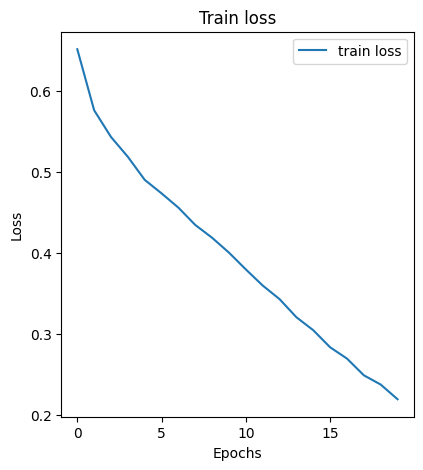

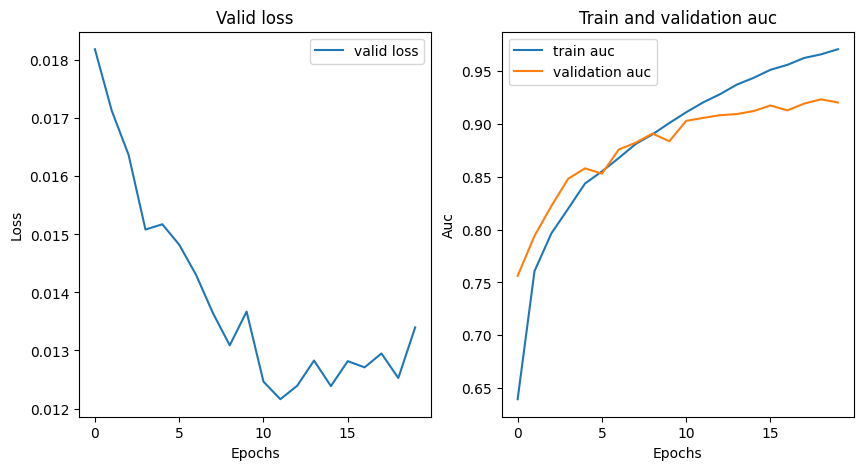

In [20]:
import matplotlib.pyplot as plt


plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='train loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train loss')
plt.legend()


plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history['valid_loss'], label='valid loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Valid loss')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(history['train_auc'], label='train auc')
plt.plot(history['valid_auc'], label='validation auc')
plt.xlabel('Epochs')
plt.ylabel('Auc')
plt.title('Train and validation auc')
plt.legend()